# Noise in bipolar cells

Bipolar cells constitute the main excitatory channel through the inner retina.

In [370]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import h5py
from scipy.stats import zscore, norm
from pyret.spiketools import binspikes
# from deepretina.toolbox import load_model, load_partial_model, rolling_window
# from deepretina.io import despine
# from deepretina.metrics import cc

%matplotlib inline
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Helper aesthetics functions

In [222]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

# Bipolar cell schematic

![title](img/retina_cartoon_and_image.png)

The image above on the right is by Josh Morgan in the Rachel Wong lab.  
Purple: Cones. Orange: Horizontal cells. <font color='green'>Green: Bipolar cells.</font> Magenta: Amacrine + Ganglion cells.

## Load bipolar cell membrane potential data  
  
A single bipolar cell's response to a Gaussian white noise visual stimulus presented twice. One pair of responses are to a 35% contrast stimulus, the other pair to a 5% contrast stimulus.

Data from David Kastner and Stephen Baccus, "Spatial Segregation of Adaptation and Predictive Sensitization in Retinal Ganglion Cells." *Neuron*. Volume 79, Issue 3. August 2013.

In [294]:
bipolar_cell_h1 = np.loadtxt('data/bipolarcell_h1.txt', skiprows=1)
bipolar_cell_h2 = np.loadtxt('data/bipolarcell_h2.txt', skiprows=1)
sampling_rate = 1000.
time = np.linspace(0,len(bipolar_cell_h1)/sampling_rate, len(bipolar_cell_h1))

In [295]:
bipolar_cell_l1 = np.loadtxt('data/bipolarcell_l1.txt', skiprows=1)
bipolar_cell_l2 = np.loadtxt('data/bipolarcell_l2.txt', skiprows=1)
sampling_rate = 1000.
time = np.linspace(0,len(bipolar_cell_l1)/sampling_rate, len(bipolar_cell_l1))

### What does the variability look like?

#### High contrast (high SNR)

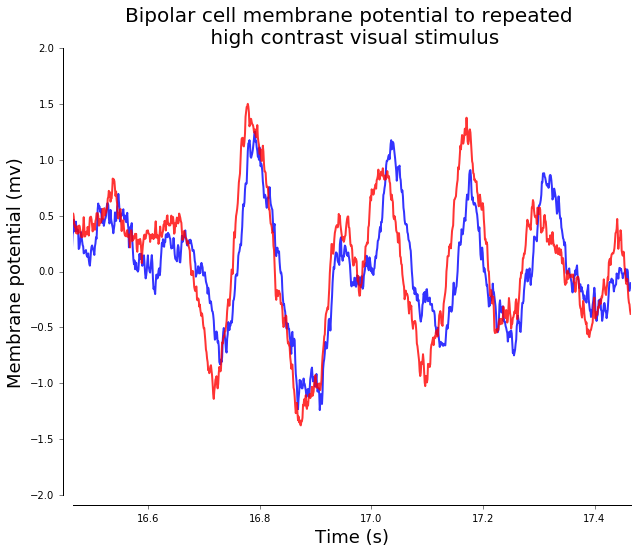

In [332]:
plt.plot(time, bipolar_cell_h1, 'b', linewidth=2, alpha=0.8)
plt.plot(time, bipolar_cell_h2, 'r', linewidth=2, alpha=0.8)
plt.title('Bipolar cell membrane potential to repeated \n high contrast visual stimulus', fontsize=20)
plt.ylabel('Membrane potential (mv)', fontsize=18)
plt.xlabel('Time (s)', fontsize=18)

# display random 1 second of data
random_start_time = np.random.choice(time[time < np.max(time)-1])
plt.xlim([random_start_time,random_start_time+1])

# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

#### Low contrast (low SNR)

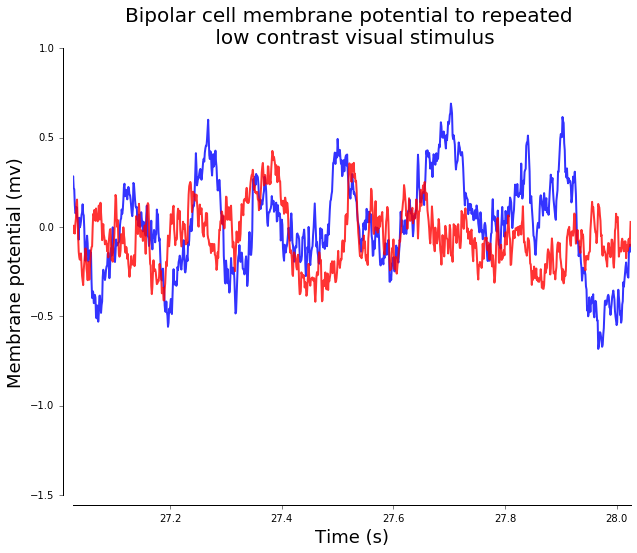

In [333]:
plt.plot(time, bipolar_cell_l1, 'b', linewidth=2, alpha=0.8)
plt.plot(time, bipolar_cell_l2, 'r', linewidth=2, alpha=0.8)
plt.title('Bipolar cell membrane potential to repeated \n low contrast visual stimulus', fontsize=20)
plt.ylabel('Membrane potential (mv)', fontsize=18)
plt.xlabel('Time (s)', fontsize=18)

# display random 1 second of data
random_start_time = np.random.choice(time[time < np.max(time)-1])
plt.xlim([random_start_time,random_start_time+1])

# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

#### Plot the residuals versus the mean.

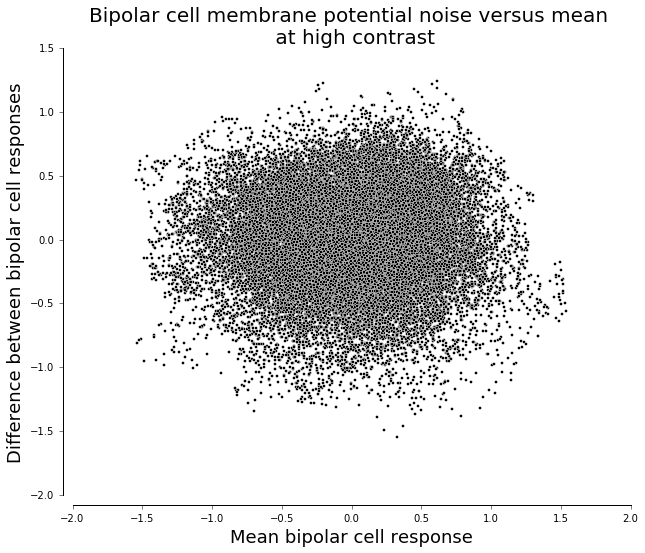

In [383]:
high_contrast_mean_response = np.mean(np.stack([bipolar_cell_h1, bipolar_cell_h2]), axis=0)
plt.plot(high_contrast_mean_response, bipolar_cell_h1-bipolar_cell_h2, 'k.', mec='w', mew=0.4)
plt.title('Bipolar cell membrane potential noise versus mean \n at high contrast', fontsize=20)
plt.xlabel('Mean bipolar cell response', fontsize=18)
plt.ylabel('Difference between bipolar cell responses', fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

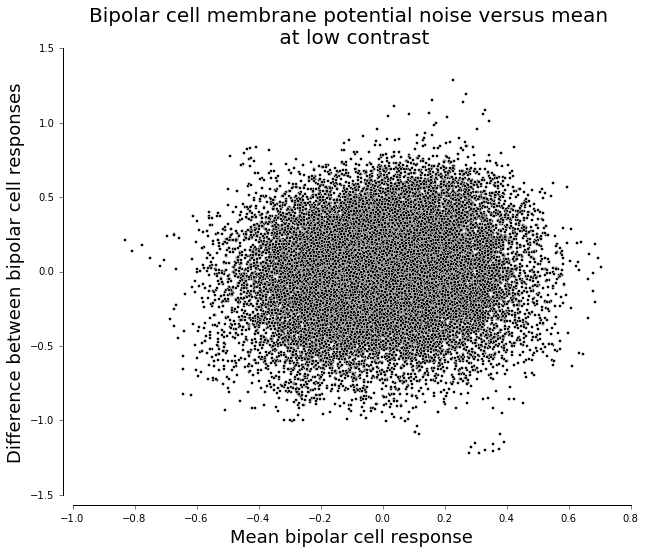

In [459]:
low_contrast_mean_response = np.mean(np.stack([bipolar_cell_l1, bipolar_cell_l2]), axis=0)
plt.plot(low_contrast_mean_response, bipolar_cell_l1-bipolar_cell_l2, 'k.', mec='w', mew=0.4)
plt.title('Bipolar cell membrane potential noise versus mean \n at low contrast', fontsize=20)
plt.xlabel('Mean bipolar cell response', fontsize=18)
plt.ylabel('Difference between bipolar cell responses', fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

### What is the distribution of noise in the high contrast case?

#### First look at distribution of all high contrast residuals

In [424]:
bipolar_residuals = bipolar_cell_h1 - bipolar_cell_h2
print('Variance of residuals is %0.3f mV, with a mean of %0.3f mV.' %(np.var(bipolar_residuals), np.mean(bipolar_residuals)))

Variance of residuals is 0.153 mV, with a mean of 0.000 mV.


In [435]:
# Get the pdf of all residuals
bipolar_data_pdf,bin_edges = np.histogram(bipolar_residuals, 100, density=True)

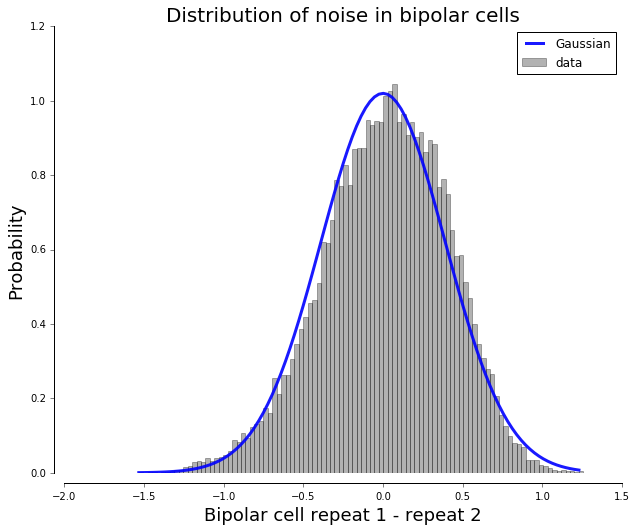

In [454]:
# Plot the data pdf and the Gaussian pdf with the same mean and variance
bin_centers = bin_edges[:-1] + np.mean(np.diff(bin_edges))/2.0
plt.bar(bin_centers, bipolar_data_pdf, np.mean(np.diff(bin_edges)), color='k', alpha=0.3, label='data')
plt.plot(bin_centers, norm(loc=np.mean(bipolar_residuals), scale=np.std(bipolar_residuals)).pdf(bin_centers),
         linewidth=3, alpha=0.9, label='Gaussian')
plt.legend()

plt.title('Distribution of noise in bipolar cells', fontsize=20)
plt.xlabel('Bipolar cell repeat 1 - repeat 2', fontsize=18)
plt.ylabel('Probability', fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

### Does the variance of the noise distribution scale with the mean, or is the distribution of noise independent of the signal mean?

In [437]:
bipolar_residual_vars = [np.var(bipolar_residuals[np.bitwise_and(high_contrast_mean_response<bin_edges[i+1],
                                                                 high_contrast_mean_response>left_edge)]) for i,left_edge
                         in enumerate(bin_edges[:-1])]

#### Plot noise variance versus mean bipolar cell membrane potential. Expectation is variance is constant at all means.

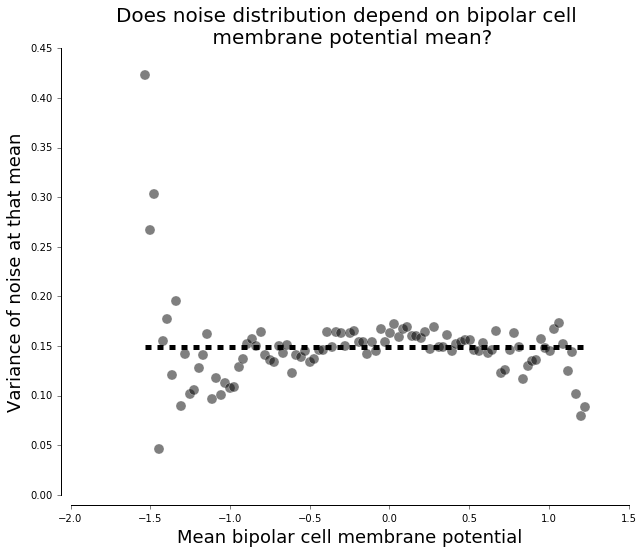

In [453]:
plt.plot(bin_centers, bipolar_residual_vars, 'k.', alpha=0.5, mec='w', markersize=20)
plt.plot(bin_centers, [np.mean(bipolar_residual_vars)]*len(bin_centers), 'k--', linewidth=5)
plt.title('Does noise distribution depend on bipolar cell \n membrane potential mean?', fontsize=20)
plt.xlabel('Mean bipolar cell membrane potential', fontsize=18)
plt.ylabel('Variance of noise at that mean', fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

## What are the relative magnitudes of noise in the high contrast versus low contrast case?

In [458]:
high_snr = np.var(high_contrast_mean_response)/np.var(bipolar_residuals)
print('For the high contrast case, the signal-to-noise ratio in bipolar cells is %0.2f.' %high_snr)

For the high contrast case, the signal-to-noise ratio in bipolar cells is 1.60.


In [460]:
low_snr = np.var(low_contrast_mean_response)/np.var(bipolar_cell_l1-bipolar_cell_l2)
print('For the low contrast case, the signal-to-noise ratio in bipolar cells is %0.2f.' %low_snr)

For the low contrast case, the signal-to-noise ratio in bipolar cells is 0.46.


# Conclusion

The difference between bipolar cell membrane potentials viewing two repeats of the identical visual stimulus are approximately Gaussian. In addition, the variance of the distribution does not appear to change with the mean bipolar membrane potential, suggesting the noise is independent of the signal.  

It therefore seems reasonable to approximate noise in bipolar cells as Gaussian.